In [89]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
import yfinance as yf
from datetime import datetime

In [90]:
# The tech stocks used for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Download stock data for each company in the tech list
for stock in tech_list:
    # Create a variable with the company ticker symbol and download data
    globals()[stock] = yf.download(stock, start, end)

# Create lists of companies and their names
company_list = [AAPL, GOOG, MSFT, AMZN]
symbols = ['AAPL', 'MSFT', 'SQ', 'AMZN']

# Extract only the relevant columns and rename them
for i, (company, symbols) in enumerate(zip(company_list, symbols)):
    # Extract columns 'Close' (closing price), 'symbols', and 'Date'
    company = company[['Close']].reset_index()

    # Rename columns for clarity
    company.columns = ['Date', 'Close']

    # Add 'Company' column
    company['symbols'] = symbols

    # Update the original list with the modified DataFrame
    company_list[i] = company

# Concatenate the modified DataFrames into one DataFrame
df = pd.concat(company_list, axis=0, ignore_index=True)

# Display the last 10 rows of the concatenated DataFrame
print(df.tail(10))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
           Date       Close symbols
994  2023-10-31  133.089996  AMZN  
995  2023-11-01  137.000000  AMZN  
996  2023-11-02  138.070007  AMZN  
997  2023-11-03  138.600006  AMZN  
998  2023-11-06  139.740005  AMZN  
999  2023-11-07  142.710007  AMZN  
1000 2023-11-08  142.080002  AMZN  
1001 2023-11-09  140.600006  AMZN  
1002 2023-11-10  143.559998  AMZN  
1003 2023-11-13  142.589996  AMZN  


In [91]:
# Define the symbols
symbols = ['AAPL', 'MSFT', 'SQ', 'AMZN']

# enerate metrics based on the number of symbols
number_of_symbols = len(symbols)

In [92]:
# Pivot the DataFrame
df_pivot = df.pivot(index='Date', columns='symbols', values='Close')

# Display the pivoted DataFrame
print(df_pivot.tail(10))

symbols           AAPL        AMZN        MSFT          SQ
Date                                                      
2023-10-31  170.770004  133.089996  125.300003  338.109985
2023-11-01  173.970001  137.000000  127.570000  346.070007
2023-11-02  177.570007  138.070007  128.580002  348.320007
2023-11-03  176.649994  138.600006  130.369995  352.799988
2023-11-06  179.229996  139.740005  131.449997  356.529999
2023-11-07  181.820007  142.710007  132.399994  360.529999
2023-11-08  182.889999  142.080002  133.259995  363.200012
2023-11-09  182.410004  140.600006  131.690002  360.690002
2023-11-10  186.399994  143.559998  134.059998  369.670013
2023-11-13  184.800003  142.589996  133.639999  366.679993


In [93]:
# Calculate the Log of returns.
log_return = np.log(1 + df.pivot_table(index='Date', columns='symbols', values='Close').pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)
rebalance_weights

array([0.28830697, 0.08634371, 0.2068922 , 0.41845712])

In [94]:
# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum(rebalance_weights * log_return.mean()) * 252

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0  0.656460        0.288307         
1  0.196600        0.086344         
2  0.471083        0.206892         
3  0.952806        0.418457         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0  0.341179                    0.227445                       1.500051              
--------------------------------------------------------------------------------


In [95]:
# Initialize the components, to run a Monte Carlo Simulation.

# run 5000 iterations.
num_of_portfolios = 5000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Create the "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct (strings)
simulations_df = simulations_df.infer_objects()

# Print the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                     Portfolio Weights
0  0.360574  0.247209    1.458583      [0.17591398283697754, 0.36871284098552104, 0.08660472443115032, 0.368768451746351]  
1  0.363812  0.252189    1.442619      [0.1798869556649594, 0.43472254792735376, 0.004640518556449307, 0.38074997785123743]
2  0.239918  0.222957    1.076077      [0.8664158230053293, 0.06240437490778403, 0.0638280489842492, 0.007351753102637554] 
3  0.329879  0.227618    1.449265      [0.3645210057672184, 0.23704927538289075, 0.08074728057347211, 0.31768243827641884] 
4  0.292493  0.230456    1.269193      [0.5061854096862377, 0.2635546966277255, 0.17152148962843333, 0.058738404057603395] 
--------------------------------------------------------------------------------


In [96]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.403847                                                                            
Volatility           0.251275                                                                            
Sharpe Ratio         1.607189                                                                            
Portfolio Weights    [0.029752612038501304, 0.08876609885493157, 0.07703303721596379, 0.8044482518906034]
Name: 3678, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns              0.288471                                                                         
Volatility           0.215669                                                                         
Sharpe Ratio         1.337563                                    

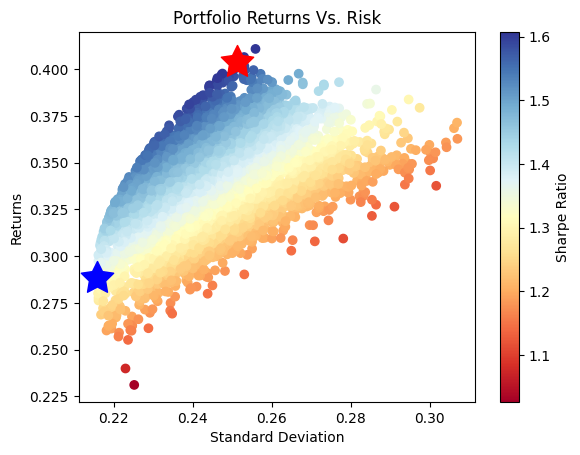

In [97]:
# see the plot inside of the Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# how the plot.
plt.show()


*   Portfolios to the upper-left part of the plot are more desirable as they offer higher returns for a given level of risk.
*   The red star represents the portfolio with the maximum Sharpe ratio, indicating the optimal risk-adjusted return.
*   The blue star represents the portfolio with the minimum volatility,indicating the lowest risk.





In [98]:
def get_metrics(weights: list, log_return) -> np.array:
    """
    Calculates and returns the portfolio returns, volatility, and Sharpe ratio based on the given set of weights.
    Arguments: weights (list): An array of portfolio weights.
    Returns: np.array: An array containing the return value, a volatility value, and a Sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.
    Arguments: weights (list): The weights being tested to see if it's the minimum.
    Returns: np.array: An array of the portfolio metrics.
    """
    return -get_metrics(weights, log_return)[2]

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.
    Arguments: weights (list): The weights, we are testing to see if it's the minimum.
    Returns: (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights, log_return)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)
    Arguments: weights (list): The weights to check to see if they sum to 1.
    Returns: float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [99]:
# Define the boundaries for each symbol. only invest up to 100% of capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# create an initial guess to start with,and usually the best initial guess is just an
# even distribution. In this case, 25% for each of the 4 stocks.
init_guess = [1 / number_of_symbols] * number_of_symbols

# Perform the operation to minimize the negative Sharpe ratio.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe,  # minimize negative Sharpe ratio
    init_guess,  # start with these values
    method='SLSQP',
    bounds=bounds,  # don't exceed these bounds
    constraints=constraints  # don't exceed the 100% constraint
)

# Print the results.
print('')
print('=' * 80)
print('OPTIMIZED SHARPE RATIO:')
print('-' * 80)
print(optimized_sharpe)
print('-' * 80)




OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.610820215905062
       x: [ 7.373e-18  3.652e-02  9.715e-02  8.663e-01]
     nit: 4
     jac: [ 3.430e-02 -1.691e-03 -6.421e-04  1.412e-04]
    nfev: 21
    njev: 4
--------------------------------------------------------------------------------


In [100]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x, log_return=log_return)

# Print the Optimized Weights.
print('')
print('=' * 80)
print('OPTIMIZED WEIGHTS:')
print('-' * 80)
print(optimized_sharpe.x)
print('-' * 80)

# Print the Optimized Metrics.
print('')
print('=' * 80)
print('OPTIMIZED METRICS:')
print('-' * 80)
print(optimized_metrics)
print('-' * 80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[7.37257477e-18 3.65246040e-02 9.71509406e-02 8.66324455e-01]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.41049509 0.25483606 1.61082022]
--------------------------------------------------------------------------------




*   The optimized weights indicate the percentage allocation of each asset in the portfolio. In this case:
Asset 1: ~0%
Asset 2: ~3.65%
Asset 3: ~9.72%
Asset 4: ~86.63%
*  The metrics include:
Expected Portfolio Returns: ~41.05%
Expected Portfolio Volatility: ~25.48%
Portfolio Sharpe Ratio: ~1.61